## 1. Data load

In [135]:
import pickle

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
with open("mon_standard.pkl", 'rb') as fi:
    data = pickle.load(fi)

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)
size = len(y)

print(f'Total samples: {size}') # Output: 19000


Loading datafile...
Total samples: 19000


## 2. Feature Extraction

In [136]:
import numpy as np
from itertools import groupby

# 새로 생성할 피처들을 저장할 리스트 초기화
features = []

# 각 피처를 계산
for i in range(len(X2)):
    size_seq = X2[i]
    time_seq = X1[i]
    
    # 1. 수신 패킷 수
    num_incoming_packets = sum(1 for size in size_seq if size < 0)
    
    # 2. 전체 패킷 수
    num_total_packets = len(size_seq)
    
    # 3. 송신 패킷 수
    num_outgoing_packets = sum(1 for size in size_seq if size > 0)
    
    # 4. 전체 패킷 중 송신 패킷 비율
    ratio_outgoing = num_outgoing_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 5. 전체 패킷 중 수신 패킷 비율
    ratio_incoming = num_incoming_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 6. 전체 수신 패킷 중 초기 30개의 수신 패킷 비율
    incoming_first_30 = sum(1 for size in size_seq[:30] if size < 0) / 30 if num_total_packets >= 30 else 0
    
    # 7. 전체 패킷 중 초기 30개의 수신 패킷 비율
    incoming_first_30_all = sum(1 for size in size_seq[:30] if size < 0) / 30 if num_total_packets >= 30 else 0
    
    # 8. 송신 버스트 중 최대 패킷 개수
    burst_outgoing_max = max(len(list(g)) for k, g in groupby(size_seq) if k > 0) if num_outgoing_packets > 0 else 0
    
    # 9. 전체 패킷 중 초기 30개의 송신 패킷 비율
    outgoing_first_30 = sum(1 for size in size_seq[:30] if size > 0) / 30 if num_total_packets >= 30 else 0
    
    # 10. 전체 송신 패킷 중 초기 30개의 송신 패킷 비율
    outgoing_first_30_all = sum(1 for size in size_seq[:30] if size > 0) / 30 if num_total_packets >= 30 else 0
    
    # 11. 마지막 5초 동안의 패킷 개수
    last_5_seconds_packets = len([size for size in size_seq[-5:] if size != 0])
    
    # 12. 송신 버스트 중 패킷 개수의 표준편차
    outgoing_burst_std = np.std([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 13. 송신 버스트의 패킷 수의 평균
    outgoing_burst_avg = np.mean([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 14. 송신 버스트 개수
    num_outgoing_bursts = len([1 for k, g in groupby(size_seq) if k > 0])
    
    # 15. 수신 버스트 개수
    num_incoming_bursts = len([1 for k, g in groupby(size_seq) if k < 0])
    
    # 16. 초기 5초 동안의 수신 버스트에서의 패킷 개수
    incoming_burst_first_5_seconds = sum(1 for size in size_seq[:5] if size < 0)
    
    # 17. 초기 5초 동안의 송신 버스트에서의 패킷 개수
    outgoing_burst_first_5_seconds = sum(1 for size in size_seq[:5] if size > 0)
    
    # 18. 수신 패킷 1초마다의 평균 개수
    incoming_per_second_avg = num_incoming_packets / (len(time_seq) / 60) if len(time_seq) > 0 else 0
    
    # 19. 전체 패킷 중 초기 5개의 수신 패킷 비율
    incoming_first_5 = sum(1 for size in size_seq[:5] if size < 0) / 5 if num_total_packets >= 5 else 0
    
    # 20. 전체 패킷 중 초기 5개의 송신 패킷 비율
    outgoing_first_5 = sum(1 for size in size_seq[:5] if size > 0) / 5 if num_total_packets >= 5 else 0
    
    # 21. 웹사이트 로딩 시간 (전체 시간)
    total_time = sum(time_seq)
    
    # 22. 전체 수신 패킷 중 초기 5개의 수신 패킷 비율
    incoming_first_5_all = sum(1 for size in size_seq[:5] if size < 0) / 5 if num_total_packets >= 5 else 0
    
    # 23. 마지막 5초 동안의 패킷의 시간 간격 평균
    last_5_seconds_time_intervals = np.mean([time_seq[i+1] - time_seq[i] for i in range(len(time_seq)-1) if time_seq[i] > 0]) if len(time_seq) > 1 else 0
    
    # 24. 전체 송신 패킷 중 초기 5개의 송신 패킷 비율
    outgoing_first_5_all = sum(1 for size in size_seq[:5] if size > 0) / 5 if num_total_packets >= 5 else 0

    # 생성된 모든 피처를 features 리스트에 추가
    features.append([
        num_incoming_packets, num_total_packets, num_outgoing_packets,
        ratio_outgoing, ratio_incoming, incoming_first_30, incoming_first_30_all,
        burst_outgoing_max, outgoing_first_30, outgoing_first_30_all, last_5_seconds_packets,
        outgoing_burst_std, outgoing_burst_avg, num_outgoing_bursts, num_incoming_bursts,
        incoming_burst_first_5_seconds, outgoing_burst_first_5_seconds, incoming_per_second_avg,
        incoming_first_5, outgoing_first_5, total_time, incoming_first_5_all,
        last_5_seconds_time_intervals, outgoing_first_5_all
    ])

# 'features'는 24개의 피처가 포함된 데이터셋
features = np.array(features)

# y는 각 샘플에 대한 레이블
y = np.array(y)


## 3. Data split and scale

In [137]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42, stratify=y)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. Train the random forest model

In [138]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=110,
    max_depth=35,
    max_features=0.5,
    random_state=42
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=35, max_features=0.5, n_estimators=110,
                       random_state=42)

## 5. Test and evaluate the model

In [156]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, precision_score, precision_recall_curve, roc_curve, recall_score, f1_score, classification_report

y_pred = rf_model.predict(X_test)

# Accuracy, Precison, Recall, F1 Score 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Confusion Matrix, ROC AUC, PR AUC 계산
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification Report 생성
class_report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(95)])

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

print(f"\nConfusion Matrix\n{conf_matrix}")
print("\nClassification Report:\n", class_report)

Accuracy: 0.7532
Precision (Weighted): 0.7549
Recall (Weighted): 0.7532
F1 Score (Weighted): 0.7500

Confusion Matrix
[[20  0  0 ...  0  0  0]
 [ 0 33  0 ...  0  0  0]
 [ 0  0 35 ...  0  0  0]
 ...
 [ 0  0  0 ... 24  0  2]
 [ 0  0  0 ...  0 39  0]
 [ 0  0  0 ...  0  0 27]]

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.74      0.50      0.60        40
     Class 1       0.77      0.82      0.80        40
     Class 2       0.88      0.88      0.88        40
     Class 3       0.81      0.88      0.84        40
     Class 4       0.70      0.78      0.74        40
     Class 5       0.70      0.78      0.74        40
     Class 6       0.71      0.85      0.77        40
     Class 7       0.89      0.97      0.93        40
     Class 8       0.76      0.80      0.78        40
     Class 9       0.77      0.85      0.81        40
    Class 10       0.93      0.70      0.80        40
    Class 11       0.74      0.72      0.73        4

## 6. Hyperparameter Tuning

In [106]:
import time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 500, 2000],
    'max_depth': [10, 20, 30],
    'min_samples_split' : [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf' : [2, 5]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=2, verbose=2)
start_time = time.time()

grid_search.fit(X_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time

print("Best_Parameters:", grid_search.best_params_)
print(f"GridSearchCV took {elapsed_time:.2f} seconds")

best_model = grid_search.best_estimator_

Fitting 2 folds for each of 108 candidates, totalling 216 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  39.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  47.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators

KeyboardInterrupt: 

## 7. Visualize the performance

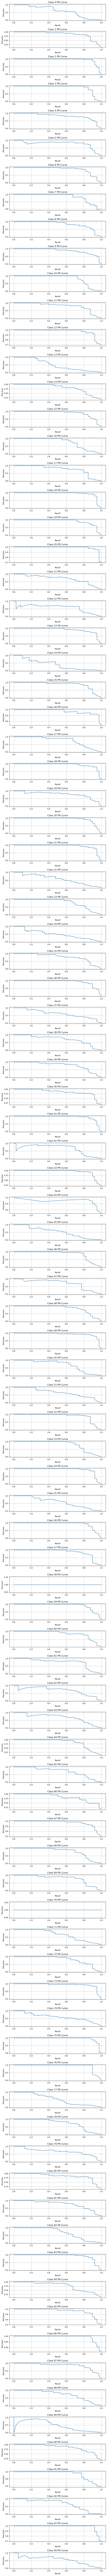

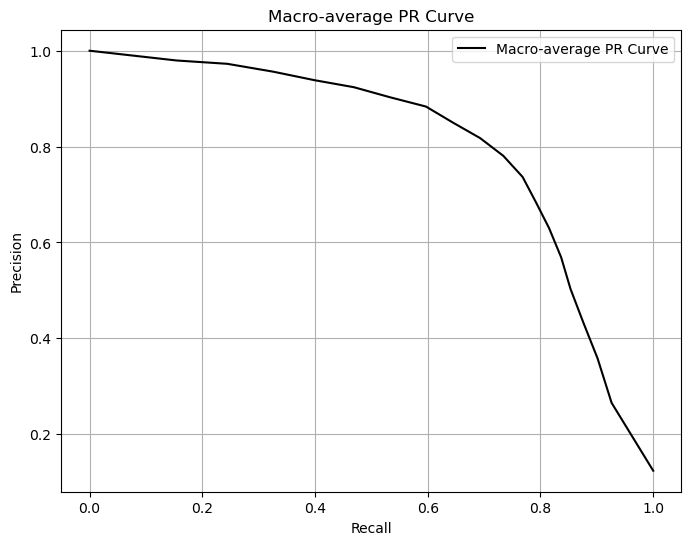

PR AUC for each class: [0.5946006244075583, 0.8617625529745975, 0.9444892616411895, 0.8928604248717033, 0.8156014716010573, 0.7827869926944825, 0.8690144320492148, 0.9665422076676168, 0.8277049787044761, 0.8661440378321938, 0.8083543322904921, 0.7930793042055122, 0.9718953169166817, 0.4875405185444305, 0.8000462261968408, 0.8829659699668085, 0.7477150615143036, 0.7567825163010973, 0.9341324992330766, 0.8999587388903842, 0.9883773967438922, 0.6940545991208256, 0.5788962156912014, 0.8948837564516203, 0.3991036483756401, 0.8580488765587821, 0.9714015522911644, 0.7393133466771217, 0.9322259276874408, 0.7750533290632299, 0.9185463624927117, 0.9304167237805042, 0.5860522127504738, 0.7855357410304501, 0.48966948554871326, 0.7716054196846406, 0.9144249535502507, 0.6224106337890235, 0.7110164779986945, 0.7803686791949489, 0.8468821631682718, 0.9367447313281198, 0.6621069559923701, 0.929623364812705, 0.9362944409205912, 0.518389908929698, 0.8413315311759387, 0.7033125874033644, 0.840789356922474

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

y_scores = rf_model.predict_proba(X_test)  

# 1. 각 클래스별 Precision, Recall 계산 후 PR Curve 그리기
n_classes = 95
fig, axes = plt.subplots(n_classes, 1, figsize=(8, 2*n_classes))  # 세로로 n_classes개의 서브플롯 생성

# 각 클래스별 Precision-Recall Curve 그리기
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test == i, y_scores[:, i])
    axes[i].plot(recall, precision)
    axes[i].set_title(f'Class {i} PR Curve')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# 2. Macro-average PR Curve 그리기
precision_macro = []
recall_macro = []

min_len = min([len(precision_recall_curve(y_test == i, y_scores[:, i])[0]) for i in range(n_classes)])

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test == i, y_scores[:, i])
    
    if len(precision) > min_len:
        precision = np.interp(np.linspace(0, 1, min_len), np.linspace(0, 1, len(precision)), precision)
        recall = np.interp(np.linspace(0, 1, min_len), np.linspace(0, 1, len(recall)), recall)
    
    precision_macro.append(precision)
    recall_macro.append(recall)

avg_precision = np.mean(precision_macro, axis=0)
avg_recall = np.mean(recall_macro, axis=0)

# Macro-average PR Curve 그리기
plt.figure(figsize=(8, 6))
plt.plot(avg_recall, avg_precision, label='Macro-average PR Curve', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Macro-average PR Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# 3. PR AUC 계산 
# 각 클래스별 PR AUC 및 Macro-average PR AUC
pr_auc_per_class = []
for i in range(n_classes):  # 각 클래스에 대한 PR AUC 계산
    pr_auc = average_precision_score(y_test == i, y_scores[:, i])
    pr_auc_per_class.append(pr_auc)

# 전체 PR AUC (Macro-average AUC) 계산
macro_pr_auc = np.mean(pr_auc_per_class)

print(f"PR AUC for each class: {pr_auc_per_class}")
print(f"Macro-average PR AUC: {macro_pr_auc}")


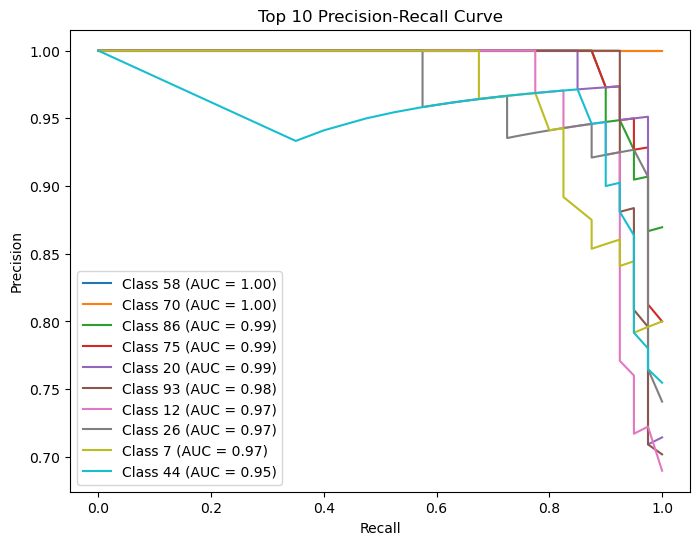

In [140]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_precision_recall_curve(y_test, y_scores, n_classes, top_n=10):
    plt.figure(figsize=(8, 6))
    
    # AUC 값 계산하여 가장 높은 top_n개의 클래스만 시각화
    auc_scores = []
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test == i, y_scores[:, i])
        pr_auc = auc(recall, precision)
        auc_scores.append((i, pr_auc))
    
    # AUC로 상위 N개의 클래스를 정렬
    auc_scores.sort(key=lambda x: x[1], reverse=True)
    
    # 상위 N개의 클래스만 시각화
    for i, _ in auc_scores[:top_n]:
        precision, recall, _ = precision_recall_curve(y_test == i, y_scores[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'Class {i} (AUC = {pr_auc:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Top {top_n} Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

y_scores = rf_model.predict_proba(X_test)
plot_precision_recall_curve(y_test, y_scores, 95, top_n=10)  # 상위 10개 클래스만 시각화


Best threshold based on F1 score: 0.30000000000000004
Precision: 0.8202669790038235
Recall: 0.7115789473684211
F1 Score: 0.7527317223808686


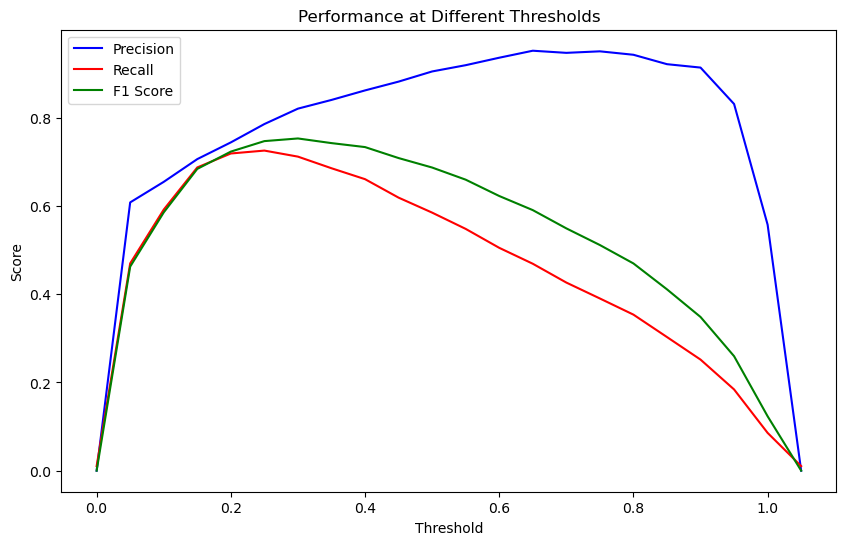

In [144]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

def plot_threshold_performance(y_test, y_scores):
    thresholds = np.arange(0.0, 1.1, 0.05)  # 예시로 0에서 1까지 0.05 간격으로 threshold 설정
    
    precision_vals = []
    recall_vals = []
    f1_vals = []
    
    # 각 threshold에 대해 모델 성능을 계산
    for threshold in thresholds:
        # y_scores의 각 클래스에 대해 가장 높은 확률을 가진 클래스를 선택
        y_pred = np.argmax(y_scores >= threshold, axis=1)  # 각 클래스에 대해 threshold 이상이면 1, 아니면 0
        precision_vals.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        recall_vals.append(recall_score(y_test, y_pred, average='weighted'))
        f1_vals.append(f1_score(y_test, y_pred, average='weighted'))
        
    # 1. 최적의 threshold
    best_threshold = thresholds[np.argmax(f1_vals)]  # F1 score가 가장 높은 threshold 선택
    print("Best threshold based on F1 score:", best_threshold)
    
    # 2. 각 클래스의 예측 확률이 threshold 이상인 경우 해당 클래스를 선택
    # y_scores는 각 클래스에 대해 예측 확률이므로, 이를 threshold와 비교하여 예측값을 결정
    y_pred = np.argmax(y_scores >= best_threshold, axis=1) 
    
    # 3. 최종 예측값을 사용하여 성능 지표 계산
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_vals, label='Precision', color='b')
    plt.plot(thresholds, recall_vals, label='Recall', color='r')
    plt.plot(thresholds, f1_vals, label='F1 Score', color='g')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Performance at Different Thresholds')
    plt.legend(loc='best')
    plt.show()

# 모델에서 예측 확률을 얻고 시각화 함수 호출
y_scores = rf_model.predict_proba(X_test)  # 예측 확률을 얻음
plot_threshold_performance(y_test, y_scores)

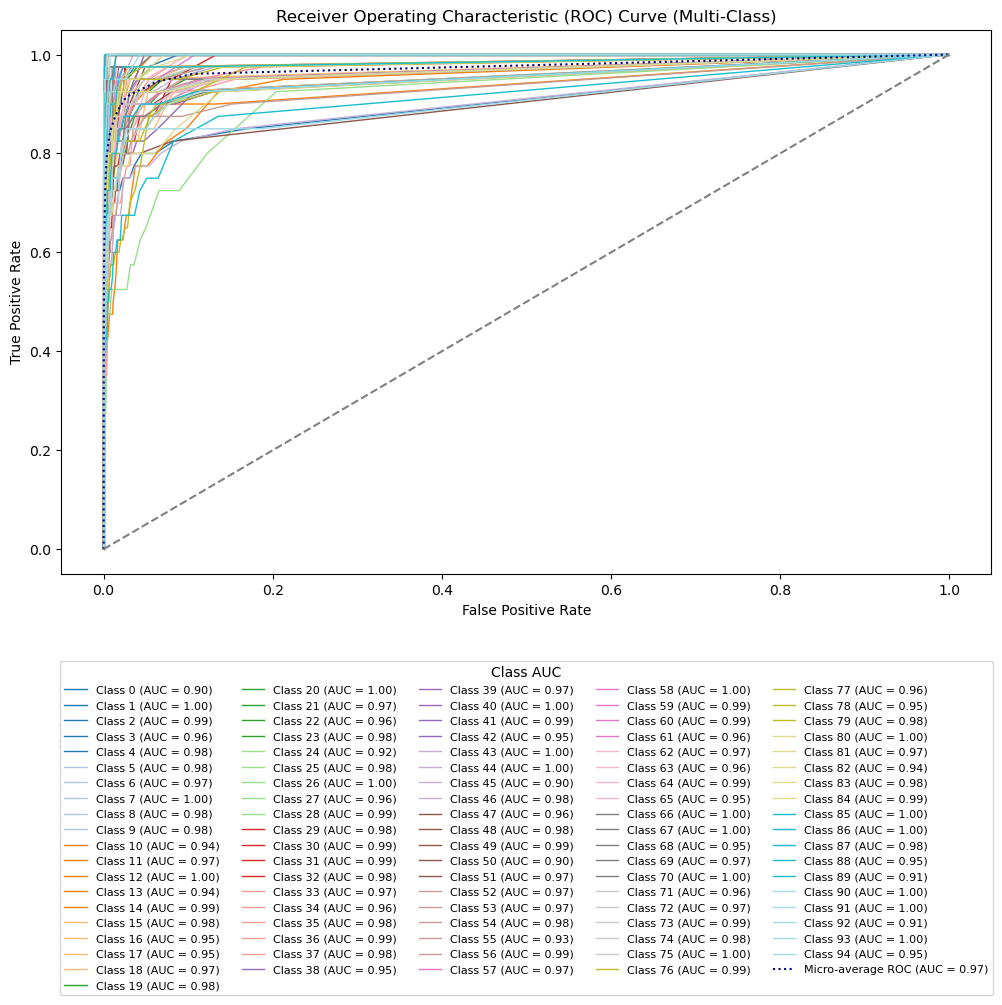

Macro-average AUC: 0.97
Micro-average AUC: 0.97


In [142]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 다중 클래스 ROC를 그리기 위해 y_test를 One-vs-Rest 방식으로 이진화
y_test_bin = label_binarize(y_test, classes=np.arange(95))  # 95개의 클래스를 이진화
y_scores = rf_model.predict_proba(X_test)  # 각 클래스에 대한 예측 확률

n_classes = y_test_bin.shape[1]

# ROC Curve 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-Averaging
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_scores.reshape(-1, n_classes).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Macro-Averaging
roc_auc_macro = np.mean(list(roc_auc.values()))

# ROC Curve 시각화
plt.figure(figsize=(12, 8))

# 각 클래스에 대해 ROC Curve 그리기
colors = plt.cm.get_cmap('tab20', n_classes)  # 다양한 색상을 사용하여 95개 클래스 표시

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=1, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Micro-Averaging ROC Curve 그리기
plt.plot(fpr_micro, tpr_micro, color='navy', linestyle=':', label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})')

# Macro-Averaging ROC Curve 그리기
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 무작위 예측선

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Multi-Class)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, title="Class AUC", fontsize=8)
plt.subplots_adjust(bottom=0.2)
plt.show()

# AUC 값 출력
print(f'Macro-average AUC: {roc_auc_macro:.2f}')
print(f'Micro-average AUC: {roc_auc_micro:.2f}')
